# タイタニック生死データを機械学習し、乗客の生死を予測する

## 1. データの前処理
### 1.1 データ読み込み

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

folder='C:\\Users\\nakam\\Python\\Data\\kaggle'
os.chdir(folder)
df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#データ確認

df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.2 欠損値分析

In [3]:
#欠損値の確認
#Cabinは欠損値が多いので、無視する

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

(-10, 85)

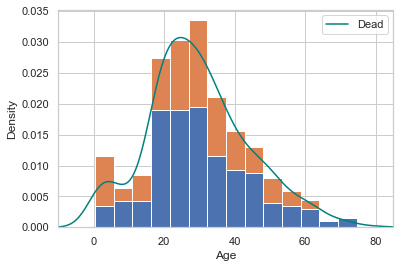

In [4]:
#Ageの欠損値処理
#ヒストグラム化してデータを確認

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df[df['Survived']==survived]) #Survivedでグループ分け

temp=[i["Age"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.hist(temp,density=True,histtype='barstacked',bins=15) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Age") #X軸
df["Age"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-10,85) #X軸範囲を指定

In [5]:
#右にゆがんだ分布なので、平均ではなく、中央値で欠損値を補完する

print(df['Age'].mean()) #平均値
print(df['Age'].median()) #中央値

29.69911764705882
28.0


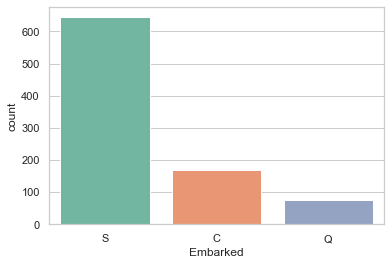

In [6]:
#Embarkedの欠損値処理
#グラフ化してデータ確認

sns.countplot(x='Embarked', data=df,palette='Set2')#paletteは色の指定
plt.show()

In [7]:
#最も多いSで補完する

df['Embarked'].value_counts().idxmax()

'S'

### 1.3 分析結果に基づき欠損値補完

In [8]:
#dfコピー
df1 = df.copy()

#欠損値補完
df1["Age"].fillna(df1["Age"].median(skipna=True), inplace=True)
df1["Embarked"].fillna(df1['Embarked'].value_counts().idxmax(), inplace=True)
df1.drop('Cabin', axis=1, inplace=True)
df1.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Q


### 1.4 欠損値補完結果確認

In [9]:
#データ確認

df1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

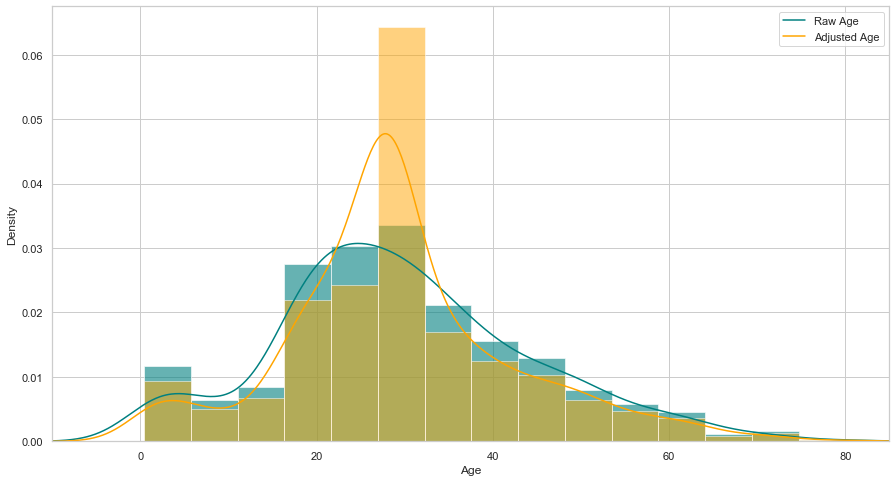

In [10]:
#Age欠損値補完結果確認

plt.figure(figsize=(15,8))
ax = df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6) #alpha=透明度
df["Age"].plot(kind='density', color='teal')
ax = df1["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df1["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

### 1.5 特徴量の作成・調整

In [11]:
#特徴量生成
df1['TravelAlone']=np.where((df1["SibSp"]+df1["Parch"])>0, 0, 1)
df1['Family']=df1['SibSp']+df1['Parch']
df1.drop('SibSp', axis=1, inplace=True)
df1.drop('Parch', axis=1, inplace=True)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1,0


In [12]:
#ダミー変数作成
df2=pd.get_dummies(df1, columns=["Pclass","Embarked","Sex"])
df2.drop('Sex_female', axis=1, inplace=True)
df2.drop('PassengerId', axis=1, inplace=True)
df2.drop('Name', axis=1, inplace=True)
df2.drop('Ticket', axis=1, inplace=True)

#男女を0,1に変換は以下のように書いてもいい
#df=df.replace('male', 0).replace('female', 1)

df2.head(6)

,Survived,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,1,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,0,1,0,0,1,1
5,0,28.0,8.4583,1,0,0,0,1,0,1,0,1


## 2. データ分析
### 2.1 Exploration of Age

(-10, 85)

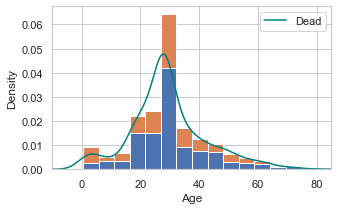

In [13]:
#ヒストグラム

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df2[df2['Survived']==survived]) #Survivedでグループ分け

temp=[i["Age"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.figure(figsize=(5,3))
plt.hist(temp,density=True,histtype='barstacked',bins=15) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Age") #X軸
df2["Age"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-10,85) #X軸範囲を指定

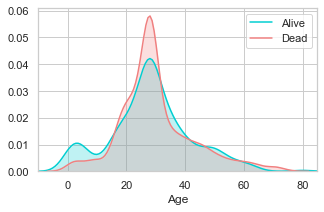

In [14]:
#分布図
#子供の生存率が高いことがわかる

plt.figure(figsize=(5,3))
ax = sns.kdeplot(df2["Age"][df2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df2["Age"][df2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Alive', 'Dead'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

      Age  Survived
0    0.42       1.0
1    0.67       1.0
2    0.75       1.0
3    0.83       1.0
4    0.92       1.0
..    ...       ...
83  70.00       0.0
84  70.50       0.0
85  71.00       0.0
86  74.00       0.0
87  80.00       1.0

[88 rows x 2 columns]


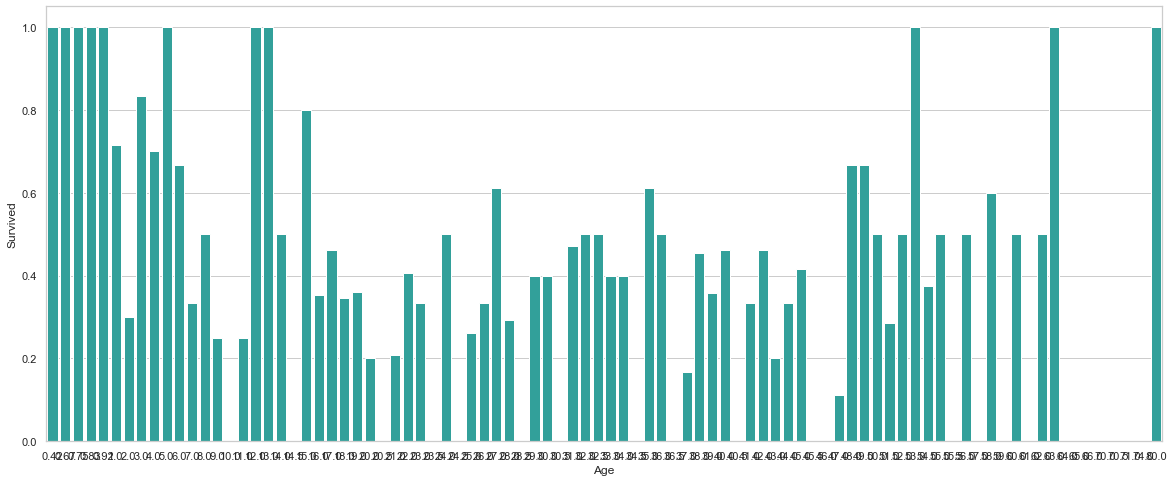

In [15]:
#Age毎の生存率をプロット

plt.figure(figsize=(20,8))
avg_survival_byage = df2[["Age", "Survived"]].groupby(['Age'], as_index=False).mean() #AgeをindexにしたくないためFalse
print(avg_survival_byage)
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

In [16]:
#15歳以下の生存率が高いので、新たな特徴量を作成

df2['IsMinor']=np.where(df2['Age']<=16, 1, 0)
df2.head()

,Survived,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0,22.0,7.2500,0,1,0,0,1,0,0,1,1,0
1,1,38.0,71.2833,0,1,1,0,0,1,0,0,0,0
2,1,26.0,7.9250,1,0,0,0,1,0,0,1,0,0
3,1,35.0,53.1000,0,1,1,0,0,0,0,1,0,0
4,0,35.0,8.0500,1,0,0,0,1,0,0,1,1,0


### 2.2 Exploration of Fare

(-20, 200)

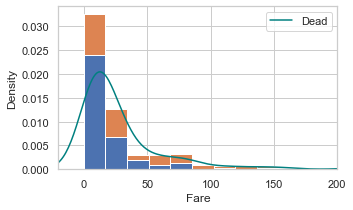

In [17]:
#ヒストグラム

split_data=[]
for survived in [0,1]: #splitにsurvived=0,1のdfを格納
    split_data.append(df2[df2['Survived']==survived]) #Survivedでグループ分け

temp=[i["Fare"].dropna() for i in split_data] #tempにsplitのデータのPlassのみ格納される

plt.figure(figsize=(5,3))
plt.hist(temp,density=True,histtype='barstacked',bins=30) #density=Trueで割合表示
plt.legend(["Dead","Alive"],loc=4) #凡例
plt.xlabel("Fare") #X軸
df2["Fare"].plot(kind='density', color='teal') #曲線を追加
plt.xlim(-20,200) #X軸範囲を指定

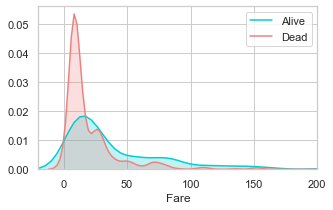

In [18]:
#分布図
#安い運賃の死亡率が高い

plt.figure(figsize=(5,3))
ax = sns.kdeplot(df2["Fare"][df2.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df2["Fare"][df2.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Alive', 'Dead'])
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

### 2.3 Exploration of Passenger Class

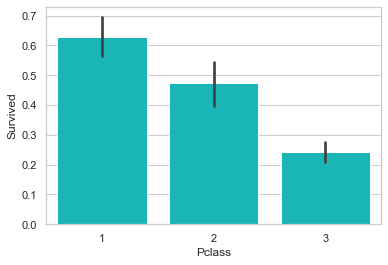

In [19]:
#クラス毎の生存率
#First Classが最も生存率が高い

sns.barplot('Pclass', 'Survived', data=df1, color="darkturquoise")
plt.show()

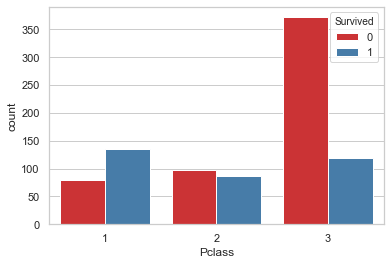

In [20]:
#棒グラフ

sns.countplot(x="Pclass", hue="Survived", palette="Set1", data=df1)

### 2.4 Exploration of Embarked Port

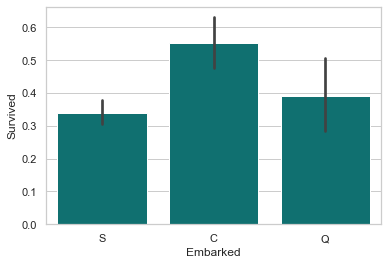

In [21]:
#搭乗地区毎の生存率

sns.barplot('Embarked', 'Survived', data=df1, color="teal")
plt.show()

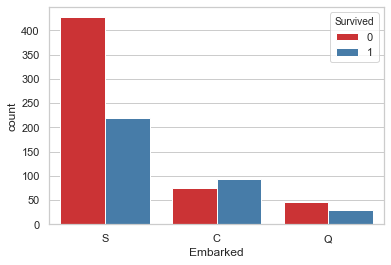

In [22]:
#棒グラフ

sns.countplot(x="Embarked", hue="Survived", palette="Set1", data=df1)

### 2.5 Exploration of Travel alone

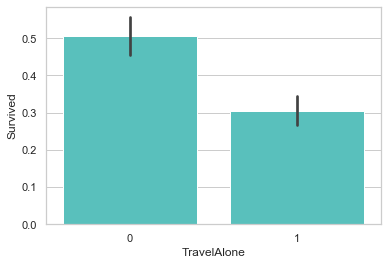

In [23]:
#一人と家族の生存率
#家族がいるほうが生存率が高い

sns.barplot('TravelAlone', 'Survived', data=df2, color="mediumturquoise")
plt.show()

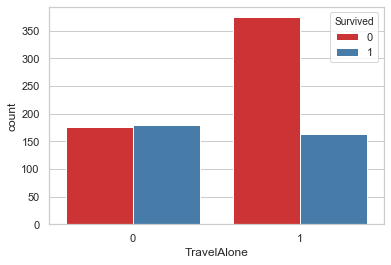

In [24]:
#棒グラフ

sns.countplot(x="TravelAlone", hue="Survived", palette="Set1", data=df1)

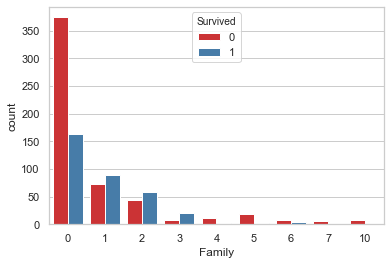

In [25]:
sns.countplot(x="Family", hue="Survived", palette="Set1", data=df1)

### 2.6 Exploration of Gender

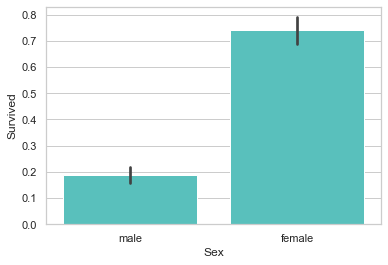

In [26]:
#性別毎の生存率
#女性のほうが生存率が高い

sns.barplot('Sex', 'Survived', data=df1, color="mediumturquoise")
plt.show()

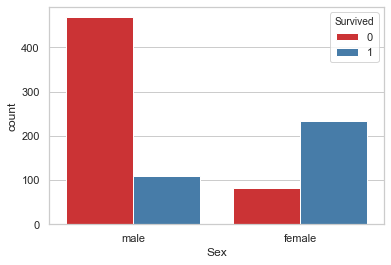

In [27]:
#棒グラフ

sns.countplot(x="Sex", hue="Survived", palette="Set1", data=df1)

## 3. 学習データの作成
### 3.1 特徴量抽出

In [28]:
#特徴量の選択
cols = ["Age","Fare","Family","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = df2[cols]
y = df2['Survived']

In [29]:
X.head(5)

,Age,Fare,Family,TravelAlone,Pclass_1,Pclass_2,Embarked_C,Embarked_S,Sex_male,IsMinor
0,22.0,7.2500,1,0,0,0,0,1,1,0
1,38.0,71.2833,1,0,1,0,1,0,0,0
2,26.0,7.9250,0,1,0,0,0,1,0,0
3,35.0,53.1000,1,0,1,0,0,1,0,0
4,35.0,8.0500,0,1,0,0,0,1,1,0


In [30]:
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### 3.2 TrainとTestにデータ分割

In [31]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
X,y,stratify=y,random_state=1)
print(X_train.shape)
print(y_train.shape)
print(np.count_nonzero(y_train==1))
print(np.count_nonzero(y_train==0))
print(np.count_nonzero(y_test==1))
print(np.count_nonzero(y_test==0))

(668, 10)
(668,)
256
412
86
137


## 4. 機械学習

In [32]:
X.head()

,Age,Fare,Family,TravelAlone,Pclass_1,Pclass_2,Embarked_C,Embarked_S,Sex_male,IsMinor
0,22.0,7.2500,1,0,0,0,0,1,1,0
1,38.0,71.2833,1,0,1,0,1,0,0,0
2,26.0,7.9250,0,1,0,0,0,1,0,0
3,35.0,53.1000,1,0,1,0,0,1,0,0
4,35.0,8.0500,0,1,0,0,0,1,1,0


### 4.1 勾配ブースティング回帰木

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

#gridを設定
param_grid={'max_depth':[1,2,3,4],'learning_rate':[0.001,0.01,0.1,1],'n_estimators':[100,300,500,700]}

#GridSearchをインスタンス化
grid=GridSearchCV(GradientBoostingClassifier(random_state=0),
                  param_grid=param_grid,scoring='roc_auc',n_jobs=-1)

#学習
grid.fit(X_train,y_train)
print('Grid-Search with accuracy')
print('Best parameters:',grid.best_params_)

print('Best cross-validation score (accuracy): {:.3f}'.format(grid.best_score_))
print('Test set AUC: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy: {:.3f}'.format(grid.score(X_test,y_test)))

Grid-Search with accuracy
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
Best cross-validation score (accuracy): 0.884
Test set AUC: 0.846
Test set accuracy: 0.846


In [34]:
#結果をデータフレームに格納
import pandas as pd
results=pd.DataFrame(grid.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.309556,0.063264,0.014836,0.016611,0.001,1,100,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.790456,0.739192,0.747655,0.764945,0.761478,0.760745,0.017532,63
1,0.711998,0.064440,0.005579,0.000802,0.001,1,300,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.790456,0.739192,0.747655,0.764945,0.761478,0.760745,0.017532,63
2,0.956880,0.066881,0.006194,0.001189,0.001,1,500,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.822584,0.739192,0.747655,0.764945,0.761478,0.767171,0.029229,62
3,1.010818,0.011312,0.007801,0.001831,0.001,1,700,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.822584,0.798134,0.803002,0.821497,0.761478,0.801339,0.022180,60
4,0.195632,0.012672,0.006226,0.001600,0.001,2,100,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.833688,0.808292,0.779784,0.825084,0.752511,0.799872,0.029989,61


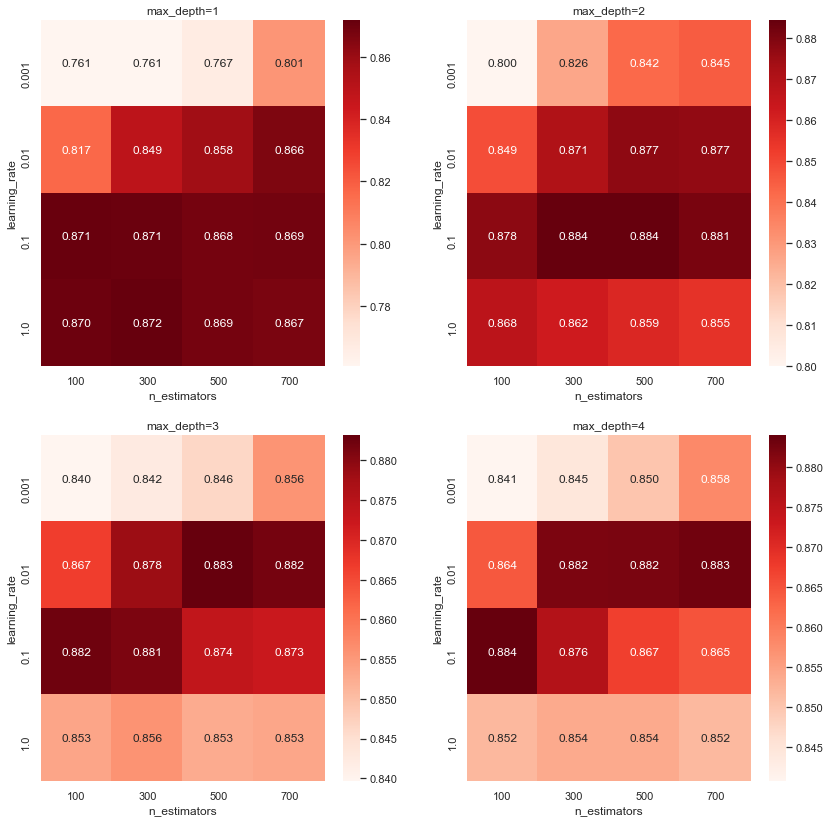

In [35]:
#全体傾向を把握
learning=[0.001,0.01,0.1,1]
n_est=[100,300,500,700]
depth=[1,2,3,4]

#グラフ作成
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(7*2,7*2))
ax=axes.flatten()

#max_depthをループ
for n in range(len(depth)):
    temp=results[results['param_max_depth']==depth[n]]
    
    #結果の箱作成
    result_map=np.zeros([4,4])
    
    #他2条件をループ
    for i in range(len(learning)):
        for j in range(len(n_est)):
            #結果を格納
            result_map[i][j]=temp[(temp['param_learning_rate']==learning[i])&(temp['param_n_estimators']==n_est[j])]['mean_test_score']
    
    #グラフ化
    import seaborn as sns
    df1=pd.DataFrame(data=result_map,index=learning,columns=n_est)
    sns.heatmap(df1,cmap='Reds',annot=True,ax=ax[n],fmt='.3f')
    ax[n].set_xlabel('n_estimators')
    ax[n].set_ylabel('learning_rate')
    ax[n].set_title('max_depth={}'.format(depth[n]))

In [36]:
#さらにメッシュを細かくして調整
#gridを設定
param_grid={'learning_rate':[0.05,0.08,0.1,0.12,0.15,0.2],'n_estimators':[300,350,400,450,500,550]}

#GridSearchをインスタンス化
grid=GridSearchCV(GradientBoostingClassifier(random_state=0,max_depth=2),
                  param_grid=param_grid,scoring='roc_auc',n_jobs=-1)

#学習
grid.fit(X_train,y_train)
print('Grid-Search with accuracy')
print('Best parameters:',grid.best_params_)


print('Best cross-validation score (accuracy): {:.3f}'.format(grid.best_score_))
print('Test set AUC: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy: {:.3f}'.format(grid.score(X_test,y_test)))

Grid-Search with accuracy
Best parameters: {'learning_rate': 0.1, 'n_estimators': 450}
Best cross-validation score (accuracy): 0.885
Test set AUC: 0.848
Test set accuracy: 0.848


Text(39.5, 0.5, 'learning_rate')

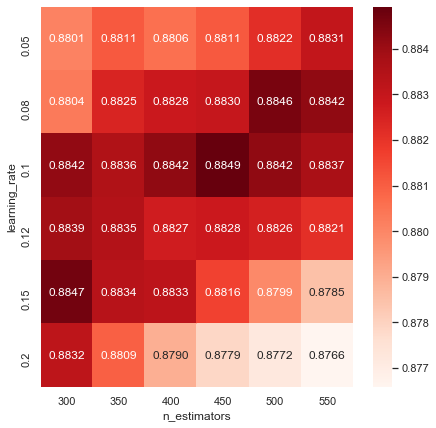

In [37]:
results=pd.DataFrame(grid.cv_results_)
temp=results

#全体傾向を把握
learning=[0.05,0.08,0.1,0.12,0.15,0.2]
n_est=[300,350,400,450,500,550]

#グラフ作成
fig,axes=plt.subplots(figsize=(7,7))
   
#結果の箱作成
result_map=np.zeros([6,6])
    
#2条件をループ
for i in range(len(learning)):
    for j in range(len(n_est)):
        #結果を格納
        result_map[i][j]=temp[(temp['param_learning_rate']==learning[i])&(temp['param_n_estimators']==n_est[j])]['mean_test_score']
    
#グラフ化
import seaborn as sns
df1=pd.DataFrame(data=result_map,index=learning,columns=n_est)
sns.heatmap(df1,cmap='Reds',annot=True,fmt='.4f')
axes.set_xlabel('n_estimators')
axes.set_ylabel('learning_rate')

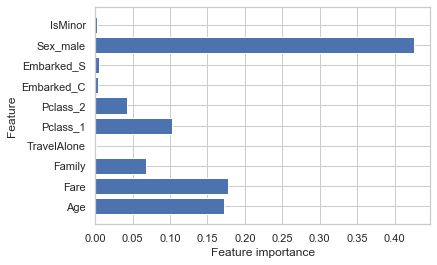

In [38]:
#特徴量の重要度をグラフ化

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model):
    n_features=len(X.columns) #特徴量の数を格納
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),X.columns) #np.arangeで0-n_featuresの配列を作成する
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(grid.best_estimator_)

In [39]:
#全データを学習
model=grid.best_estimator_
model.fit(X,y)
print("Accuracy on training set: {:.3f}".format(model.score(X,y)))

Accuracy on training set: 0.915


In [40]:
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=450,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 5. 結果出力
### 5.1 Testデータ読み込み

In [41]:
#testデータ読み込み
df_test=pd.read_csv('test.csv')
df_test.head()

#欠損値確認
df_test.isnull().sum() #欠損値確認

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 5.2 Testデータの前処理

In [42]:
#Trainデータと同様の処理を行う

test_data = df_test.copy()
test_data["Age"].fillna(df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)
test_data['Family']=test_data['SibSp']+test_data['Parch']
test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)
final_test.head()

,Age,Fare,TravelAlone,Family,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,34.5,7.8292,1,0,0,0,1,0,1,0,1,0
1,47.0,7.0000,0,1,0,0,1,0,0,1,0,0
2,62.0,9.6875,1,0,0,1,0,0,1,0,1,0
3,27.0,8.6625,1,0,0,0,1,0,0,1,1,0
4,22.0,12.2875,0,2,0,0,1,0,0,1,0,0


In [43]:
#特徴量抽出

cols = ["Age","Fare","Family","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X_final_test = final_test[cols]

In [45]:
import csv
print("Test set predictions: {}".format(model.predict(X_final_test))) #テスト
output=model.predict(X_final_test)

Test set predictions: [0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 0 0]


In [46]:
with open("predict_gbrt.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(df_test["PassengerId"].astype(int), output.astype(int)):
        writer.writerow([pid, survived])